### Data Description & Analysis

###Cats vs Dogs Detector (CaDoD)

**Traning Data** - This contains about images of cats and dogs in jpg format. The images are of various resolution and are RGB scale. 

**Test Data** - Test data contains images of cats and dogs.


####Data preprocessing
- The data has to be rescaled to a specific aspect ratio.
- Shuffling the train set can be benificial option.
- Rescaled training data is saved for easy load in the future.

The image archive `cadod.tar.gz` is a subset [Open Images V6](https://storage.googleapis.com/openimages/web/download.html). It contains a total of 12,966 images of dogs and cats.


Image bounding boxes are stored in the csv file `cadod.csv`. The following describes whats contained inside the csv.

* ImageID: the image this box lives in.
* Source: indicates how the box was made:
    * xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
    * activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
* LabelName: the MID of the object class this box belongs to.
* Confidence: a dummy value, always 1.
* XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
* XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.

The attributes have the following definitions:

* IsOccluded: Indicates that the object is occluded by another object in the image.
* IsTruncated: Indicates that the object extends beyond the boundary of the image.
* IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
* IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
* IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).
For each of them, value 1 indicates present, 0 not present, and -1 unknown.

In [19]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import tarfile
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive,files
drive.mount('/content/gdrive')

# Google collab dir: Account: kikarand@iu.edu
DATA_DIR="gdrive/MyDrive/data/"

extract_path = 'images/'
image_file_name = 'cadod.tar.gz'
bounding_box_file_name = 'cadod.csv'


image_path = os.path.join(DATA_DIR, image_file_name)
bounding_box_path = os.path.join(DATA_DIR, bounding_box_file_name)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
extract_path = 'images/'
image_file_name = 'cadod.tar.gz'
bounding_box_file_name = 'cadod.csv'


image_path = os.path.join(DATA_DIR, image_file_name)
bounding_box_path = os.path.join(DATA_DIR, bounding_box_file_name)
resize_path = os.path.join(extract_path, "resized")

In [ ]:
!mkdir -p $resize_path

# Import Data

### Unarchive data

In [2]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [18]:
extract_tar(image_path, extract_path)

  0%|          | 0/25936 [00:00<?, ?it/s]

### Load bounding box meta data

In [20]:
df = pd.read_csv(bounding_box_path)

In [21]:
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000b9fcba019d36,xclick,/m/0bt9lr,1,0.165000,0.903750,0.268333,0.998333,1,1,...,0,0,0.636250,0.903750,0.748750,0.165000,0.268333,0.506667,0.998333,0.661667
1,0000cb13febe0138,xclick,/m/0bt9lr,1,0.000000,0.651875,0.000000,0.999062,1,1,...,0,0,0.312500,0.000000,0.317500,0.651875,0.000000,0.410882,0.999062,0.999062
2,0005a9520eb22c19,xclick,/m/0bt9lr,1,0.094167,0.611667,0.055626,0.998736,1,1,...,0,0,0.487500,0.611667,0.243333,0.094167,0.055626,0.226296,0.998736,0.305942
3,0006303f02219b07,xclick,/m/0bt9lr,1,0.000000,0.999219,0.000000,0.998824,1,1,...,0,0,0.508594,0.999219,0.000000,0.478906,0.000000,0.375294,0.720000,0.998824
4,00064d23bf997652,xclick,/m/0bt9lr,1,0.240938,0.906183,0.000000,0.694286,0,0,...,0,0,0.678038,0.906183,0.240938,0.522388,0.000000,0.370000,0.424286,0.694286


# Exploratory Data Analysis

## Statistics

In [22]:
print(f"There are a total of {len(glob.glob1(path, '*.jpg'))} images")

There are a total of 12966 images


In [23]:
print(f"The total size is {os.path.getsize(path)/1000} MB")

The total size is 1077.248 MB


In [24]:
df.shape

(12966, 21)

Replace `LabelName` with human readable labels

In [25]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)

In [26]:
df.LabelName.value_counts()

dog    6855
cat    6111
Name: LabelName, dtype: int64

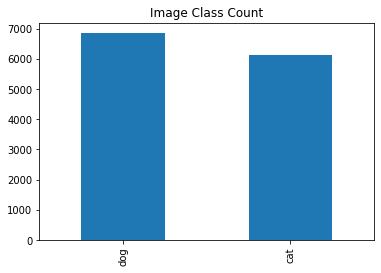

In [27]:
df.LabelName.value_counts().plot(kind='bar')
plt.title('Image Class Count')
plt.show()

In [28]:
df.describe()

,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
count,12966.0,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000
mean,1.0,0.099437,0.901750,0.088877,0.945022,0.464754,0.738470,0.013651,0.045427,0.001157,0.390356,0.424582,0.494143,0.506689,0.275434,0.447448,0.641749,0.582910
std,0.0,0.113023,0.111468,0.097345,0.081500,0.499239,0.440011,0.118019,0.209354,0.040229,0.358313,0.441751,0.405033,0.462281,0.415511,0.401580,0.448054,0.403454
min,1.0,0.000000,0.408125,0.000000,0.451389,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.0,0.000000,0.830625,0.000000,0.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221292,0.096875,0.285071,0.130000,0.024323,0.218333,0.405816,0.400000
50%,1.0,0.061250,0.941682,0.059695,0.996875,0.000000,1.000000,0.000000,0.000000,0.000000,0.435625,0.415625,0.531919,0.623437,0.146319,0.480838,0.825000,0.646667
75%,1.0,0.167500,0.998889,0.144853,0.999062,1.000000,1.000000,0.000000,0.000000,0.000000,0.609995,0.820000,0.787500,0.917529,0.561323,0.729069,0.998042,0.882500
max,1.0,0.592500,1.000000,0.587088,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999375,0.999375,1.000000,0.999375,0.999375,0.999375,1.000000,0.999375


## Sample of Images

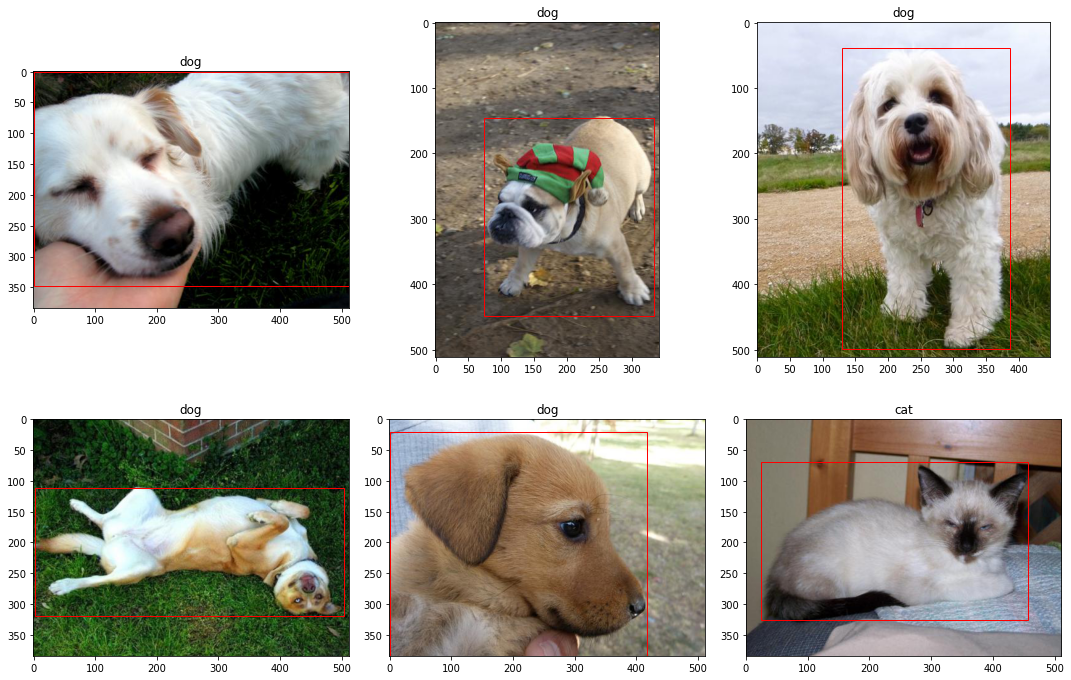

In [29]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

## Image shapes and sizes

Go through all images and record the shape of the image in pixels and the memory size

In [30]:
img_shape = []
img_size = np.zeros((df.shape[0], 1))

for i,f in enumerate(tqdm(glob.glob1(path, '*.jpg'))):
    file = path+'/'+f
    img = Image.open(file)
    img_shape.append(f"{img.size[0]}x{img.size[1]}")
    img_size[i] += os.path.getsize(file)

  0%|          | 0/12966 [00:00<?, ?it/s]

Count all the different image shapes

In [31]:
img_shape_count = Counter(img_shape)

In [32]:
# create a dataframe for image shapes
img_df = pd.DataFrame(set(img_shape_count.items()), columns=['img_shape','img_count'])

In [33]:
img_df.shape

(594, 2)

There are a ton of different image shapes. Let's narrow this down by getting a sum of any image shape that has a cout less than 100 and put that in a category called `other`

In [34]:
img_df = img_df.append({'img_shape': 'other','img_count': img_df[img_df.img_count < 100].img_count.sum()}, 
                       ignore_index=True)

Drop all image shapes

In [35]:
img_df = img_df[img_df.img_count >= 100]

Check if the count sum matches the number of images

In [36]:
img_df.img_count.sum() == df.shape[0]

True

Plot

## TODO plot aspect ratio

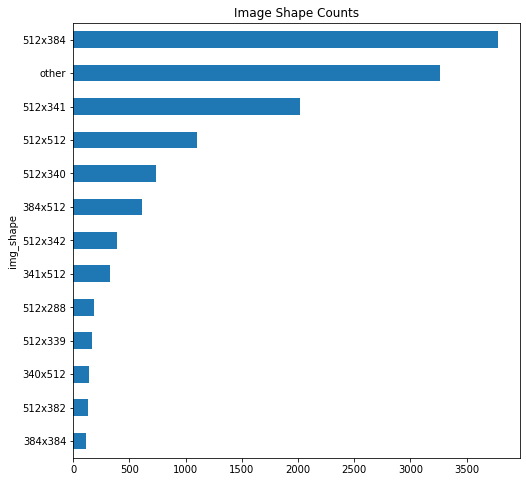

In [37]:
img_df.sort_values('img_count', inplace=True)
img_df.plot(x='img_shape', y='img_count', kind='barh', figsize=(8,8), legend=False)
plt.title('Image Shape Counts')
plt.show()

In [38]:
# convert to megabytes
img_size = img_size / 1000

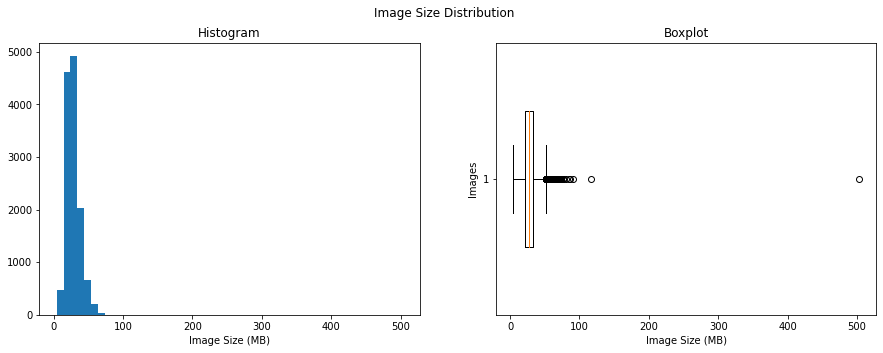

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Image Size Distribution')
ax[0].hist(img_size, bins=50)
ax[0].set_title('Histogram')
ax[0].set_xlabel('Image Size (MB)')
ax[1].boxplot(img_size, vert=False, widths=0.5)
ax[1].set_title('Boxplot')
ax[1].set_xlabel('Image Size (MB)')
ax[1].set_ylabel('Images')
plt.show()

# Preprocess

## Rescale the images

In [51]:
import os
import glob

files = glob.glob(f'{resize_path}/*')
for f in files:
    os.remove(f)

In [52]:
%%time
# resize image and save, convert to numpy

img_arr = np.zeros((df.shape[0],32*32*3)) # initialize np.array

for i, f in enumerate(tqdm(df.ImageID)):
    img = Image.open(extract_path+f+'.jpg')
    img_resized = img.resize((32,32))
    img_resized.save(os.path.join(resize_path,f"{f}.jpg"), "JPEG", optimize=True)
    img_arr[i] = np.asarray(img_resized, dtype=np.uint8).flatten()

  0%|          | 0/12966 [00:00<?, ?it/s]

CPU times: user 1min 4s, sys: 2.21 s, total: 1min 6s
Wall time: 1min 7s


In [53]:
print(len(img_arr[0]))

3072


Plot the resized and filtered images

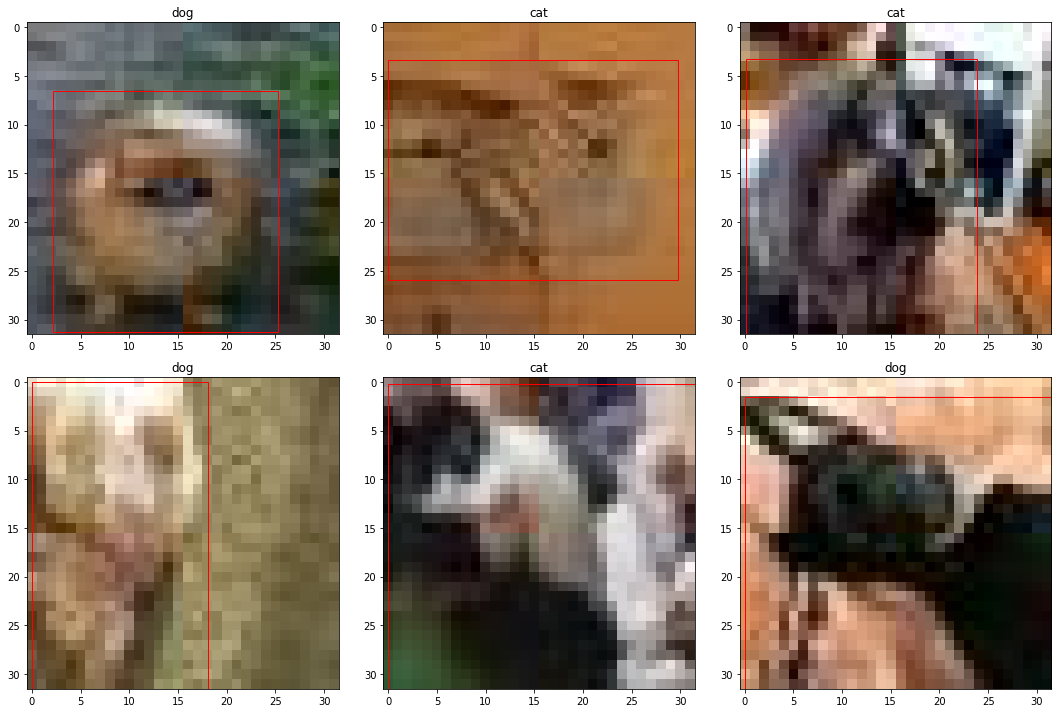

In [55]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(f"{resize_path}/"+df.ImageID.values[j]+'.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j,2])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

In [56]:
# encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

### Comparing Images Before and After

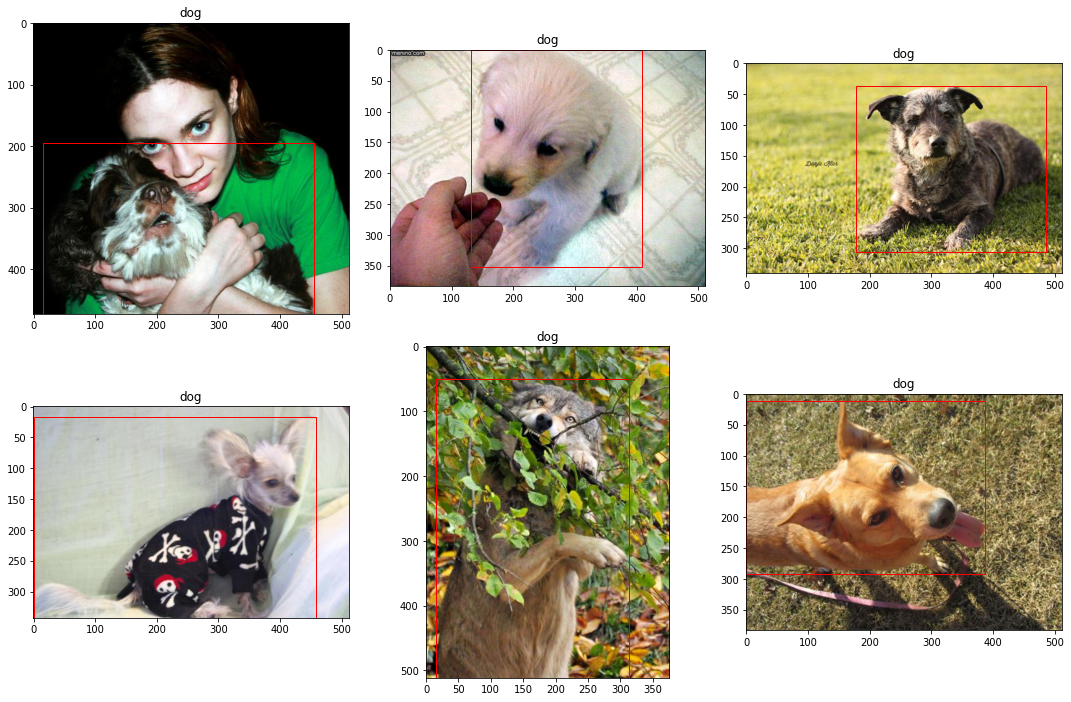

In [57]:
# plot first 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(df.index[5584:5590].to_numpy()):
    img = mpimg.imread(extract_path + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

## Checkpoint and Save data

In [58]:
mkdir -p \data

In [59]:
np.save('data/img.npy', img_arr.astype(np.uint8))
np.save('data/y_label.npy', df.Label.values)
np.save('data/y_bbox.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32))

# Baseline in SKLearn

## Load data

In [60]:
X = np.load('data/img.npy', allow_pickle=True)
y_label = np.load('data/y_label.npy', allow_pickle=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True)

In [61]:
idx_to_label = {1:'dog', 0:'cat'} # encoder

Double check that it loaded correctly

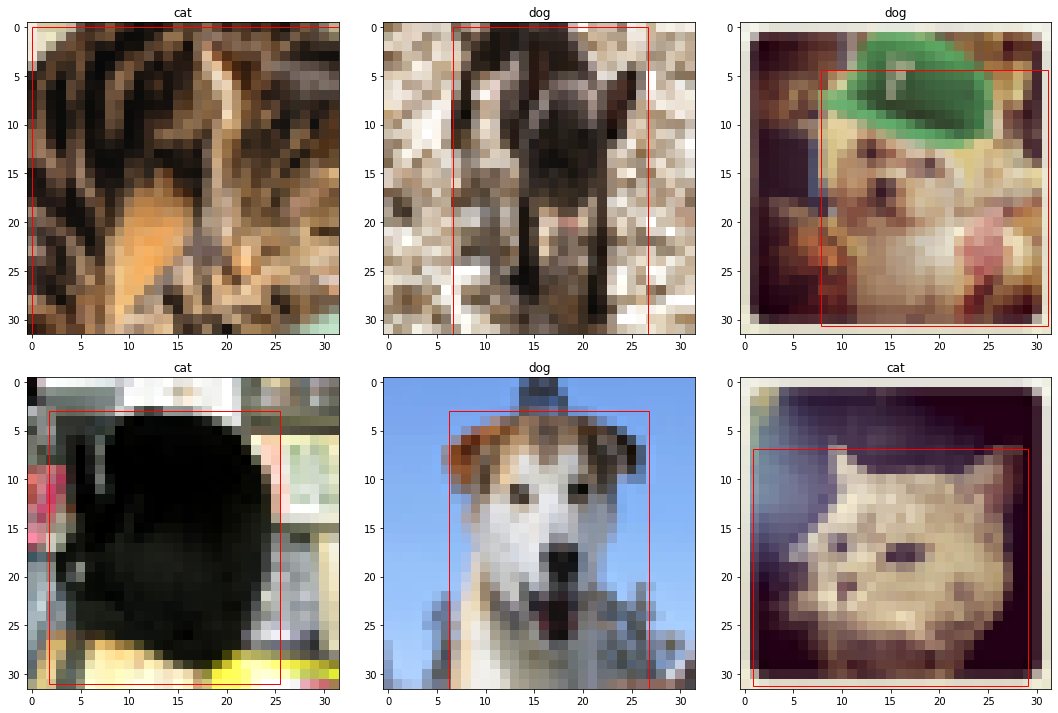

In [62]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X.shape[0], size=6, replace=False)):
    coords = y_bbox[j] * 32
    ax[i].imshow(X[j].reshape(32,32,3))
    ax[i].set_title(idx_to_label[y_label[j]])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

## Classification

### Split data

Create training and testing sets

In [63]:
X_train, X_test, y_train, y_test_label = train_test_split(X, y_label, test_size=0.01, random_state=27)

### Train

I'm choosing `SGDClassifier` because the data is large and I want to be able to perform stochastic gradient descent and also its ability to early stop. With this many parameters, a model can easily overfit so it's important to try and find the point of where it begins to overfit and stop for optimal results.

In [64]:
%%time
model = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10, 
                      early_stopping=True, validation_fraction=0.1, n_iter_no_change=3)
# 0.2 validation TODO
model.fit(X_train, y_train)

CPU times: user 1.11 s, sys: 509 ms, total: 1.62 s
Wall time: 1.2 s


In [65]:
model.n_iter_

4

Did it stop too early? Let's retrain with a few more iterations to see. Note that `SGDClassifier` has a parameter called `validation_fraction` which splits a validation set from the training data to determine when it stops.

In [66]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

In [67]:
model2 = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10)

epochs = 30

train_acc = np.zeros(epochs)
valid_acc = np.zeros(epochs)
for i in tqdm(range(epochs)):
    model2.partial_fit(X_train, y_train, np.unique(y_train))
    
    #log
    train_acc[i] += np.round(accuracy_score(y_train, model2.predict(X_train)),3)
    valid_acc[i] += np.round(accuracy_score(y_valid, model2.predict(X_valid)),3)

  0%|          | 0/30 [00:00<?, ?it/s]

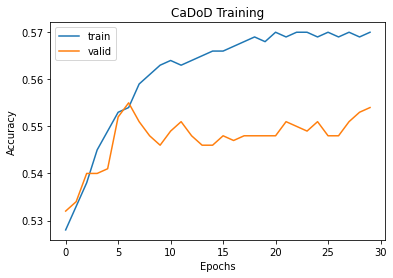

In [68]:
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.title('CaDoD Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [69]:
del model2

### Evaluation

In [75]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Acc", 
                               "Valid Acc",
                               "Test  Acc",
                               "Train MSE", 
                               "Valid MSE",
                               "Test  MSE",
                              ])

In [76]:
exp_name = f"Baseline: Linear Model"
expLog.loc[0,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test_label, model.predict(X_test))],3))

In [77]:
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train MSE,Valid MSE,Test MSE
0,Baseline: Linear Model,0.565,0.557,0.615,NaN,NaN,NaN


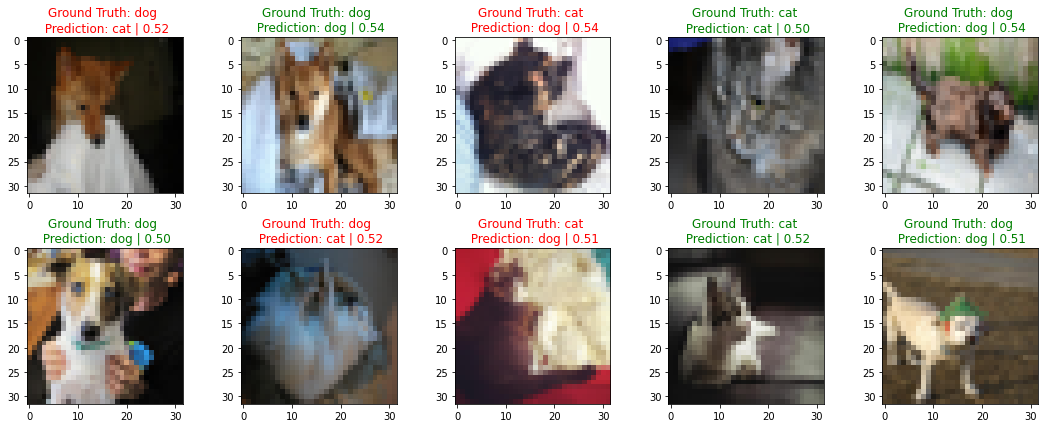

In [78]:
y_pred_label = model.predict(X_test)
y_pred_label_proba = model.predict_proba(X_test)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False,figsize=(15,6))
ax = ax.flatten()

for i in range(10):
    img = X_test[i].reshape(32,32,3)
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[i]],
                                                                   idx_to_label[y_pred_label[i]],
                                                                   y_pred_label_proba[i][y_pred_label[i]]),
                   color=("green" if y_pred_label[i]==y_test_label[i] else "red"))

plt.tight_layout()
plt.show()

In [79]:
# imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

## Regression

### Split data

In [80]:
d1 = []
for i1 in img_arr:
    d1.append(i1)
temp_image_data=[]
for i in range(0,len(df)):
    temp_image_data.append(pd.Series(data = d1).iloc[i])

In [81]:
len(temp_image_data)
len(img_arr[0])

3072

In [82]:
X_train, X_test, y_train, y_test = train_test_split(np.array(temp_image_data), y_bbox, test_size=0.01, random_state=27)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

### Train

In [83]:
%%time

from sklearn.linear_model import LinearRegression
# TODO closed loop solution, could use Lasso Ridge
model = LinearRegression() #fill in 
model.fit(X_train, y_train)

# might take a few minutes to train
#CPU times: user 1h 26min 40s, sys: 5min 53s, total: 1h 32min 34s
#Wall time: 17min 24s

CPU times: user 41.3 s, sys: 3.98 s, total: 45.3 s
Wall time: 28.4 s


### Baseline Linear regression with lasso and ridge

### Evaluation

In [84]:
expLog.iloc[0,4:] = list(np.round([mean_squared_error(y_train, model.predict(X_train)), 
          mean_squared_error(y_valid, model.predict(X_valid)), 
          mean_squared_error(y_test, model.predict(X_test))],3))

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train MSE,Valid MSE,Test MSE
0,Baseline: Linear Model,0.565,0.557,0.615,0.007,0.015,0.015


In [85]:
# The below code is refered from Hw5
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
np.random.seed(42)

estimators = [('ridge', Ridge()),
              ('lasso', Lasso())]

best_score = []
best_param = []
for estimator in estimators:
    params = {estimator[0]+'__alpha':[.01, .05, .1, .5, 1, 5]}
    # set up the pipeline using the standard scaler and estimator
    # and grid search with pipeline, params, 
    # and correct scoring parameter (scoring parameter has to be a utility- where bigger is better 
    # such as neg_mean_squared_error, explained_variance etc. )
    # for more information see the following - 
    #     https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    # Please use neg_mean_squared_error here.
    #==================================================#
    #               Your code starts here              #
    #==================================================#
 
    # TODO - change above to
    pipe = Pipeline([('scalar', StandardScaler()), estimator])
    gs = GridSearchCV(pipe, params, scoring='neg_mean_squared_error',cv=5)
    #==================================================#
    #               Your code ends here                #
    #==================================================#
    
    gs.fit(X_train, y_train)
    best_score.append(gs.best_score_)
    best_param.append(gs.best_params_)
best_idx = np.argmax(best_score)
print('Best model is:', estimators[best_idx][0], 'with parameter', best_param[best_idx])

Best model is: lasso with parameter {'lasso__alpha': 0.01}


In [86]:
list(best_param[best_idx].values())[0]

0.01

In [87]:
#estimator = estimators[best_idx][0], list(best_param[best_idx].values())[0])
estimator = [Ridge, Lasso][best_idx]
param = list(gs.best_params_.values())[0]
print (param)
# set up the pipeline using the best estimator
pipe = Pipeline([('scalar', StandardScaler()), ('estimator', estimator(alpha=param))])
pipe.fit(X_train, y_train)

0.01


Pipeline(steps=[('scalar', StandardScaler()), ('estimator', Lasso(alpha=0.01))])

In [88]:
exp_name = f"Linear Regression(best regularization and alpha)"
expLog.loc[1,:4] = [f"{exp_name}"] +list(np.round([0, 
          0, 
          0],3))
expLog.loc[1,4:] = list(np.round([mean_squared_error(y_train, pipe.predict(X_train)), 
          mean_squared_error(y_valid, pipe.predict(X_valid)), 
          mean_squared_error(y_test, pipe.predict(X_test))],3))
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train MSE,Valid MSE,Test MSE
0,Baseline: Linear Model,0.565,0.557,0.615,0.007,0.015,0.015
1,Linear Regression(best regularization and alpha),0,0,0,0.01,0.011,0.009


### Modelling Pipelines
### Baseline

In [89]:
# Below code is refered from HW13, Hw7,Hw2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
X = np.load('data/img.npy', allow_pickle=True)
y_label = np.load('data/y_label.npy', allow_pickle=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'}
X_train_class, X_test_class, y_train_label, y_test_label = train_test_split(X, y_label, stratify=y_label, shuffle=True, test_size=0.50, random_state=27)
np.random.seed(42)
X = X.astype(np.float32) / 255.
y_label=y_label.astype(int)

X_train_class, X_test_class, y_train_label, y_test_label = train_test_split(X, y_label, stratify=y_label, shuffle=True, test_size=0.20, random_state=27)

X_train_full = X_train_class
y_train_full = y_train_label
X_test_full = X_test_class
y_test_full = y_test_label

X_train, _, y_train, _ = train_test_split(X_train_class, y_train_label, stratify=y_train_label, train_size=0.1, random_state=42)

X_test, _, y_test, _ = train_test_split(X_test_class, y_test_label, stratify=y_test_label, train_size=0.1, random_state=42)

In [90]:
# use full pipeline above to build full pipeline with predictor
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("linear", LogisticRegression(random_state=42))
    ])

full_pipeline_with_predictor.fit(X_train, y_train)

Pipeline(steps=[('linear', LogisticRegression(random_state=42))])

In [91]:
start = time()
full_pipeline_with_predictor.fit(X_train, y_train)
np.random.seed(42)

# Set up cross validation scores 
# Use ShuffleSplit() with 30 splits, 30% test_size 
# and a random seed of 0
#==================================================#
#               Your code starts here              #
#==================================================#
cv3Splits = ShuffleSplit(n_splits=3, random_state=0, test_size=0.30, train_size=None)
logit_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv3Splits)     
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#
logit_score_train = logit_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(X_test, y_test)
test_time = np.round(time() - start, 4)

In [92]:
results = pd.DataFrame(columns=["Expname", "Train accuracy", "Test Accuracy"])
results.loc[0] = ["Baseline", np.round(100*logit_score_train,1), np.round(np.round(100*logit_score_test,1),3)]
results

,Expname,Train accuracy,Test Accuracy
0,Baseline,54.0,55.2


In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(loss='log',
                                        penalty='l2',
                                        early_stopping=True,
                                        max_iter=10000, tol=1e-5,
                                        random_state=42)),
        
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Naive Bayes': {},
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'tol': (0.0001, 0.0000001), 
            'alpha': (0.1, 0.001, 0.0001), 
        }
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, 
                                   n_jobs=n_jobs, verbose=verbose)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = np.round(100*grid_search.best_score_,1)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)
        
# #         plt.barh(['Age', 'Parch', 'SibSp','Fare','x0_C' ,'x0_Q' ,'x0_S' ,'x1_female', 'x1_male' ,'x2_1' ,'x2_2', 'x2_3'], grid_search.best_estimator_.named_steps["predictor"].feature_importances_)
# #         plt.show()
#         features = ['Age', 'Parch', 'SibSp','Fare','x0_C' ,'x0_Q' ,'x0_S' ,'x1_female', 'x1_male' ,'x2_1' ,'x2_2', 'x2_3']
#         importances = grid_search.best_estimator_.named_steps["predictor"].feature_importances_
#         indices = np.argsort(importances)

#         plt.title('Feature Importances')
#         plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#         plt.yticks(range(len(indices)), [features[i] for i in indices])
#         plt.xlabel('Relative Importance')
#         plt.grid()
#         plt.show();
        # Best estimator prediction time
        start = time()
        best_test_accuracy = np.round(100*grid_search.best_estimator_.score(X_test, y_test),1)
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        # To calculate the best_train_accuracy use the pct() and mean() methods
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv3Splits)
        best_train_accuracy = np.round(100*best_train_scores.mean(),1)
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#    
       
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy]

In [94]:
ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:",  n_jobs=-1,verbose=1)

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters:
	predictor__C: 0.01
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:
	predictor__n_neighbors: 11
	predictor__p: 2
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Naive Bayes *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:
****** FINISH Best Model: Naive Bayes  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Para

In [95]:
results

,Expname,Train accuracy,Test Accuracy
0,Baseline,54.0,55.2
1,Best Model:Logistic Regression,56.9,53.3
2,Best Model:K-Nearest Neighbors,53.0,56.0
3,Best Model:Naive Bayes,54.0,55.2
4,Best Model:Support Vector,56.1,52.9
5,Best Model:Stochastic GD,52.9,57.9


# Homegrown implementation

Implement a Homegrown Logistic Regression model. Extend the loss function from CXE to CXE + MSE, i.e., make it a complex multitask loss function the resulting model   predicts the class and bounding box coordinates at the same time.

# Results / Discussion

Cats and Dogs Classification is a popular ML problem, which can be solved using various techniques. We performed algorithms like logistic regression, KNN, Naive Baye’s, Support Vector, Stochastic Gradient Descent, to find out how well these algorithms can predict class for the cat and dog image set. 
- Among all the models Gradient Descent proved to be better, with accuracy of 57.9 and the runner up is KNN. 
- We have also implemented Baseline linear regression along with Baseline LR with Lasso and Ridge(with alpha and best parameters). Lasso and Ridge metrics performed better.


# Challenges :

The main challenges was to work with a huge dataset.
Hence we decreased image size from 128x128 to 32x32.


# Conclusion

In phase 1, we have focused on the SKLearn Baseline models for logistic regression, SGDClassifier to classify the images into cats and dogs and Linear regression for making the bounding boxes around the cats and dogs inside the image.
Well, Test Accuracy alone can’t tell how good an algorithm predicts the classes in general on various data set. We hope to experiment more by implementing homegrown logistic regression model and CNN in the next phase. 
